In [243]:
%load_ext autoreload
%autoreload 2

from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from context import ml_project
from ml_project.io import DataHandler
from sklearn.preprocessing import StandardScaler

# To surpress sklearn warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
_ = np.seterr(divide='ignore', invalid='ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
print(tf.__version__)

1.13.1


# How-To

1) Download the zip folder holding the data  
2) Create a directory inside the PROJECT_ROOT_DIR/data and give it a suitable name DIR_NAME, e.g. "task1b_data"   
3) Extract the files from the zip folder into <DIR_NAME>  
4) Set the correct DIR_NAME in the following cell...  (no need for full absolute path)

In [6]:
DIR_NAME = 'task2_data'

# Load Data and aggregate feature matrix

In [7]:
data_handler = DataHandler(DIR_NAME)
train_data = data_handler.load_train_data()
final_test_data = data_handler.load_test_data()  # only used for submission

In [252]:
HELD_OUT_TEST_SET_SIZE = 0.2  # used for out of sample classifier performance evaluation

In [253]:
X_train, X_test, y_train, y_test = train_test_split(train_data.drop(['y'], axis=1), 
                                                    train_data['y'], 
                                                    test_size=HELD_OUT_TEST_SET_SIZE,
                                                    random_state=42)

X_train, X_test, y_train, y_test = X_train.as_matrix(), X_test.as_matrix(), y_train.as_matrix(), y_test.as_matrix()

In [254]:
# StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Visualizing the data set

In [255]:
from pandas.plotting import scatter_matrix

SHOW_PLOT = False  # switch to True if you want to see the scatter plot
if SHOW_PLOT:
    _ = scatter_matrix(pd.concat([y_train, X_train], axis=1), alpha=0.3, figsize=(12, 12))

# Build the model

In [264]:
model = keras.Sequential([
    keras.layers.Dense(20, activation=tf.nn.relu),
    
    keras.layers.Dense(100, activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.3, noise_shape=None, seed=None),
    
    keras.layers.Dense(100, activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.3, noise_shape=None, seed=None),

    keras.layers.Dense(3, activation=tf.nn.softmax)
])

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=60, validation_split=0.2, verbose=0, shuffle=True, workers=-1)

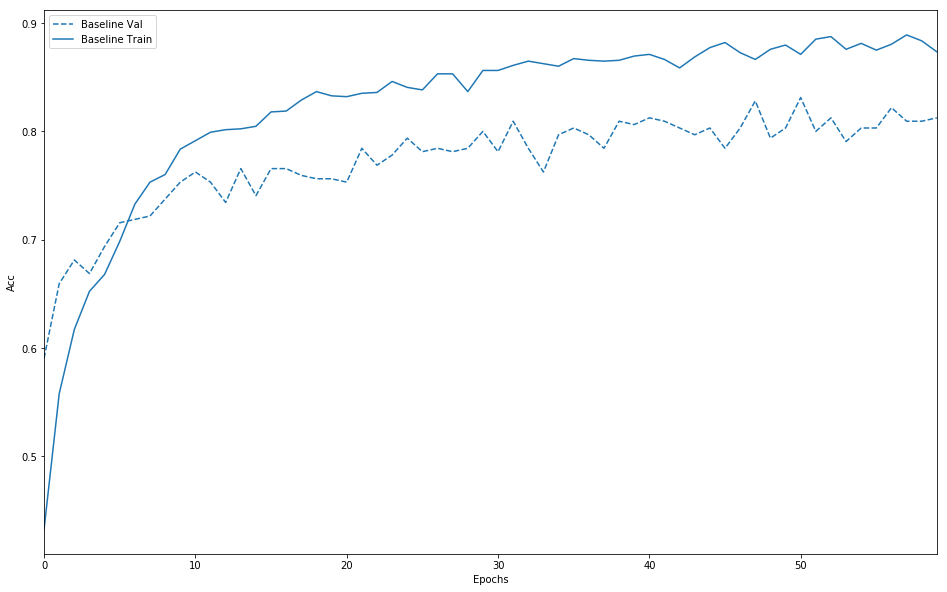

In [265]:
def plot_history(models, key='acc'):
    plt.figure(figsize=(16,10))

    for name, model in models:
        history = model.history
        try:
            val = plt.plot(history.epoch, history.history['val_'+key],
                           '--', label=name.title()+' Val')
        except:
            pass
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])


plot_history([('baseline', model)])  # can add more models as needed

In [266]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

400/400 [==============================] - 0s 54us/sample - loss: 0.5423 - acc: 0.8400
Test accuracy: 0.84


# Performance evaluation on held out test dat
This is the section where we get a sense of how well our trained model is doing on the part of the training set we did not touch during training.

In [267]:
from scikitplot.metrics import plot_confusion_matrix
from scikitplot.metrics import plot_roc

In [268]:
model=bigger_history
try:
    y_pred_proba = model.predict(X_test)
    y_pred = [np.argmax(proba) for proba in y_pred_proba]
except:
    pass


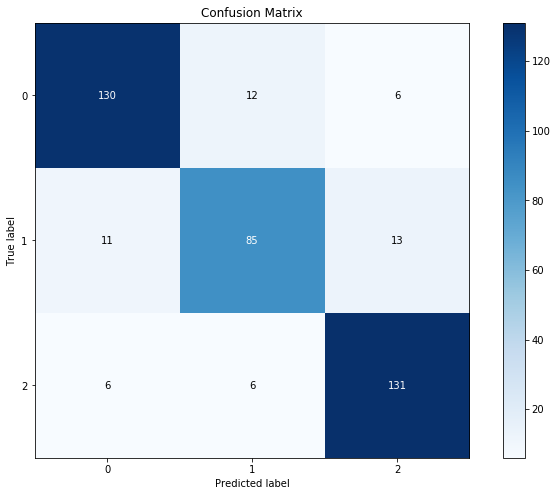

In [269]:
_ = plot_confusion_matrix(y_test, y_pred, figsize=(12, 8))

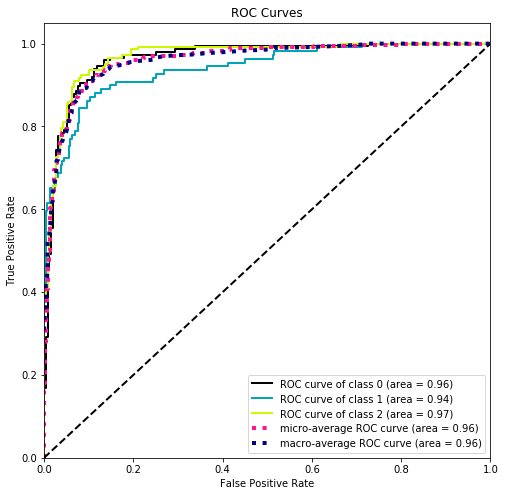

In [270]:
_ = plot_roc(y_test, y_pred_proba, figsize=(8, 8))

# Perform prediction on provided test data set
Now we perform predictions on the provided, unlabelled data set for submission

In [271]:
y_pred_final = [np.argmax(proba) for proba in model.predict(final_test_data)]
y_pred_ids = final_test_data.index

# Store the data
Putting everything into the right format and storing the results in the working data directory

In [272]:
data_handler.store_results_task2(y_pred_final, y_pred_ids)